In [ ]:
#change init W,b
#change train: XY_act,XY_act,XY_actder, loss
#change test: XY_act,XY_act, loss
#change ff: XY_act,XY_act


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import copy

data = load_breast_cancer()
y_indices = data.target
y = np.matrix(data.target).T
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

print(X.shape)

print(y.shape)

(569, 30)
(569, 1)


In [2]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
m_test = M - m_train
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
# y_test_indices = y_indices[test_idx]
print('=======X train =======')
print(X_train.shape,y_train.shape)
print('=======X test =======')
print(X_test.shape,y_test.shape)

=======X train =======
(341, 30) (341, 1)
=======X test =======
(228, 30) (228, 1)


In [3]:
# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h2 = 5
h1 = 6
W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,1])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[1,1])]
L = len(W)-1


In [4]:
def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def tanh_act(z):
    return np.tanh(z)

def tanh_actder(z):
    az = act(z)
    prod = np.multiply(az,az)
    return (1 - prod)

def relu_act(z):
    return np.maximum(0,z)

def relu_actder(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

def linear_act(z):
    return z
    
def linear_actder(z):
    return 1


In [5]:
def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = softmax_act(z)
        else:
            a = sigmoid_act(z)
    return a

####MSE
# def loss_multi(y, yhat):
#     return - np.dot(y, np.log(yhat))

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

def loss_mse(y,yhat):
    return np.power(y-yhat,2)

In [6]:
# Train for 100 epochs with mini-batch size 1

cost_arr = [] 
cost_arr_test = []
best_this_loss = 1e-16
alpha = 0.01
max_iter = 1000
iter_stop = 0

for iter in range(0, max_iter):
    loss_this_iter = 0
    loss_this_iter_test = 0
    order = np.random.permutation(m_train)
    order_test = np.random.permutation(m_test)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(sigmoid_act(z[l]))
            else:
                a.append(sigmoid_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                # depends on your activation function in th at particular layer 
                # in this case all our activation functions are sigmoid 
                delta[l-1] = np.multiply(sigmoid_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):            
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
        
    for j in range(0, m_test):

        # Grab the pattern order[j]

        x_this_test = X_test[order_test[j],:].T
        y_this_test = y_test[order_test[j],:]

        # Feed forward step
        a_test = [x_this_test]
        z_test = [[]]
        for l in range(1,L+1):
            z_test.append(W[l].T*a_test[l-1]+b[l])
            if (l == L):
                a_test.append(sigmoid_act(z_test[l]))
            else:
                a_test.append(sigmoid_act(z_test[l]))
        
        loss_this_pattern_test = loss_mse(y_this_test,a_test[L])
        loss_this_iter_test = loss_this_iter_test + loss_this_pattern_test
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.


    cost_arr.append(loss_this_iter[0,0])
    cost_arr_test.append(loss_this_iter_test[0,0])
    
    if loss_this_iter_test < best_this_loss:
        w_best = copy.deepcopy(w)
        b_best = copy.deepcopy(b)
        iter_best = iter
        print('Early stopping at Epoch %d' % (iter))
        break
    
#     tol = 0.0001
#     if len(cost_arr_test) > 50:
#         if cost_arr_test[-2] - cost_arr_test[-1] < tol:
#             iter_stop = iter
#             print('Epoch %d train loss %f' % (iter, loss_this_iter))
#             print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
#             print('Iter stop: ', iter_stop)
#             break

    print('Epoch %d train loss %f' % (iter, loss_this_iter))
    print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
    iter_stop = iter


Epoch 0 train loss 119.044750
Epoch 0 test loss 52.343155
Epoch 1 train loss 107.351007
Epoch 1 test loss 51.886296
Epoch 2 train loss 105.327021
Epoch 2 test loss 51.698119
Epoch 3 train loss 102.879492
Epoch 3 test loss 51.749556
Epoch 4 train loss 101.403886
Epoch 4 test loss 51.938503
Epoch 5 train loss 104.403825
Epoch 5 test loss 51.743310
Epoch 6 train loss 103.024717
Epoch 6 test loss 51.677036
Epoch 7 train loss 98.554302
Epoch 7 test loss 52.183734
Epoch 8 train loss 97.599246
Epoch 8 test loss 52.971904
Epoch 9 train loss 108.419544
Epoch 9 test loss 51.680278
Epoch 10 train loss 103.363618
Epoch 10 test loss 51.303186
Epoch 11 train loss 103.171138
Epoch 11 test loss 50.893036
Epoch 12 train loss 101.976986
Epoch 12 test loss 50.532607
Epoch 13 train loss 96.018554
Epoch 13 test loss 50.493976
Epoch 14 train loss 99.320491
Epoch 14 test loss 49.948123
Epoch 15 train loss 97.576651
Epoch 15 test loss 49.269472
Epoch 16 train loss 94.410490
Epoch 16 test loss 48.426518
Epoch 

In [7]:
# Get test set accuracy

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i,:].T, W, b))
    return y_pred

y_test_predicted = predict_y(W, b, X_test)
y_correct = y_test_predicted == y_test
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 78.0000


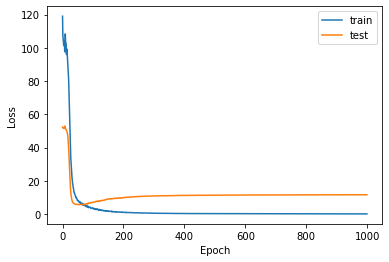

In [8]:
plt.plot(np.arange(0,iter_stop+1,1), cost_arr, label = "train")
plt.plot(np.arange(0,iter_stop+1,1), cost_arr_test, label = "test")

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()